<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/OCRModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Change working
%cd /content/drive/My Drive/Colab Notebooks/ocr

/content/drive/My Drive/Colab Notebooks/ocr


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Neural network libraies
import tensorflow as tf
print(f'Tensorflow version: {tf.__version__}')

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

# Config display
%config InlineBackend.figure_format = 'retina'

Tensorflow version: 2.7.0
GPU is available


In [3]:
# Import A-Z dataset
az_data = pd.read_csv('A_Z Handwritten Data.csv')
print(f'Total rows: {az_data.shape[0]}, Total columns: {az_data.shape[1]}')

Total rows: 372450, Total columns: 785


In [4]:
# Extra A-Z images from dataframe
az_labels = []
az_images = []

for i in range(az_data.shape[0]):
  if i % 50000 == 0:
    print(f'Processing image done: {i}')
  label = az_data.iloc[i][0]
  image = az_data.iloc[i][1:].values
  image = image.reshape((28, 28))

  # Append data
  az_labels.append(label)
  az_images.append(image)

del az_data

# Covert to numpy array
az_labels = np.array(az_labels)
az_images = np.array(az_images)
print(f'A-Z Labels shape: {az_labels.shape}')
print(f'A-Z Images shape: {az_images.shape}')

Processing image done: 0
Processing image done: 50000
Processing image done: 100000
Processing image done: 150000
Processing image done: 200000
Processing image done: 250000
Processing image done: 300000
Processing image done: 350000
A-Z Labels shape: (372450,)
A-Z Images shape: (372450, 28, 28)


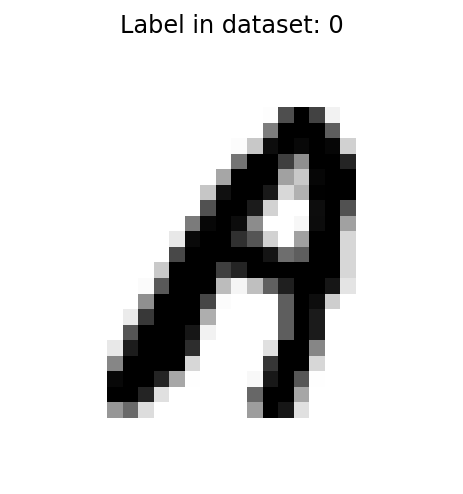

In [5]:
# Show A-Z images
plt.imshow(az_images[0], cmap = plt.cm.binary)
plt.title(f'Label in dataset: {az_labels[0]}')
plt.axis('off')
plt.show()

In [6]:
# Import MNIST dataset (0-9)
((mnist_images_train, mnist_labels_train), (mnist_images_test, mnist_labels_test)) = mnist.load_data()
print(f'MNIST Train shape: {mnist_images_train.shape}')
print(f'MNIST Test shape: {mnist_images_test.shape}')

11501568/11490434 [==============================] - 0s 0us/step
MNIST Train shape: (60000, 28, 28)
MNIST Test shape: (10000, 28, 28)


In [7]:
# Combine MNIST dataset
mnist_labels = np.hstack([mnist_labels_train, mnist_labels_test])
mnist_images = np.vstack([mnist_images_train, mnist_images_test])

del mnist_labels_train, mnist_labels_test, mnist_images_train, mnist_images_test

print(f'MNIST Labels shape: {mnist_labels.shape}')
print(f'MNIST Images shape: {mnist_images.shape}')

MNIST Labels shape: (70000,)
MNIST Images shape: (70000, 28, 28)


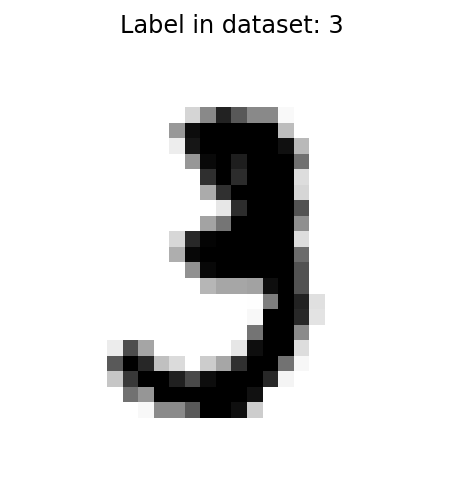

In [9]:
# Show MNIST images
plt.imshow(mnist_images[10], cmap = plt.cm.binary)
plt.title(f'Label in dataset: {mnist_labels[10]}')
plt.axis('off')
plt.show()

In [10]:
# Combine A-Z and MNIST dataset
az_labels = az_labels + 10 #This to ensure that A-Z labels is not overlab with MNIST (0-9 labels)

labels = np.hstack((az_labels, mnist_labels))
images = np.vstack((az_images, mnist_images))

del az_labels, mnist_labels, az_images, mnist_images

print(f'Labels shape: {labels.shape}')
print(f'Images shape: {images.shape}')

# Convert images to float32
images = images.astype(np.float32)

Labels shape: (442450,)
Images shape: (442450, 28, 28)


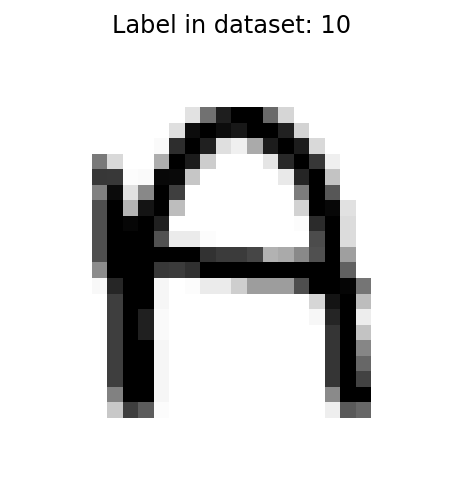

In [11]:
# Show images
plt.imshow(images[100], cmap = plt.cm.binary)
plt.title(f'Label in dataset: {labels[100]}')
plt.axis('off')
plt.show()

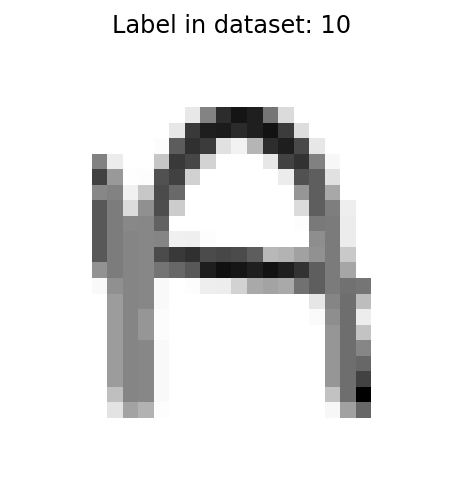

In [12]:
# Normalised images to be (0-1)
images = normalize(images, axis = 1)

# Show images
plt.imshow(images[100], cmap = plt.cm.binary)
plt.title(f'Label in dataset: {labels[100]}')
plt.axis('off')
plt.show()

In [13]:
# Reshape images for neural network
images = images.reshape(images.shape[0], 28, 28, 1)
print(f'Reshape images shape: {images.shape}')

Reshape images shape: (442450, 28, 28, 1)


In [14]:
# Train test splits
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.20, random_state = 777)

del images, labels

print(f'Training images shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing images shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training images shape: (353960, 28, 28, 1)
Training labels shape: (353960,)
Testing images shape: (88490, 28, 28, 1)
Testing labels shape: (88490,)


In [16]:
# Model condition
# Images augmentation
aug = ImageDataGenerator(rotation_range = 10,
                         zoom_range = 0.05,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.2,
                         horizontal_flip = False,
                         fill_mode = 'nearest')

#Defining the optimizer
optz = tf.keras.optimizers.Adam(learning_rate = 0.01)

In [17]:
# Neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(36, activation = 'softmax')) #(0-9) + (A-Z) = 36
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optz, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [18]:
# Fit model
logs = model.fit(aug.flow(X_train, y_train, batch_size = 512), validation_data = (X_test, y_test), epochs = 50)

Epoch 1/50
692/692 [==============================] - 158s 215ms/step - loss: 0.6429 - accuracy: 0.8136 - val_loss: 0.1796 - val_accuracy: 0.9451
Epoch 2/50
692/692 [==============================] - 148s 214ms/step - loss: 0.3086 - accuracy: 0.9084 - val_loss: 0.1690 - val_accuracy: 0.9483
Epoch 3/50
692/692 [==============================] - 148s 214ms/step - loss: 0.2767 - accuracy: 0.9179 - val_loss: 0.1718 - val_accuracy: 0.9480
Epoch 4/50
692/692 [==============================] - 149s 215ms/step - loss: 0.2649 - accuracy: 0.9217 - val_loss: 0.1514 - val_accuracy: 0.9544
Epoch 5/50
692/692 [==============================] - 148s 214ms/step - loss: 0.2578 - accuracy: 0.9237 - val_loss: 0.1551 - val_accuracy: 0.9548
Epoch 6/50
692/692 [==============================] - 148s 213ms/step - loss: 0.2501 - accuracy: 0.9263 - val_loss: 0.1512 - val_accuracy: 0.9547
Epoch 7/50
692/692 [==============================] - 148s 214ms/step - loss: 0.2578 - accuracy: 0.9244 - val_loss: 0.1598 -

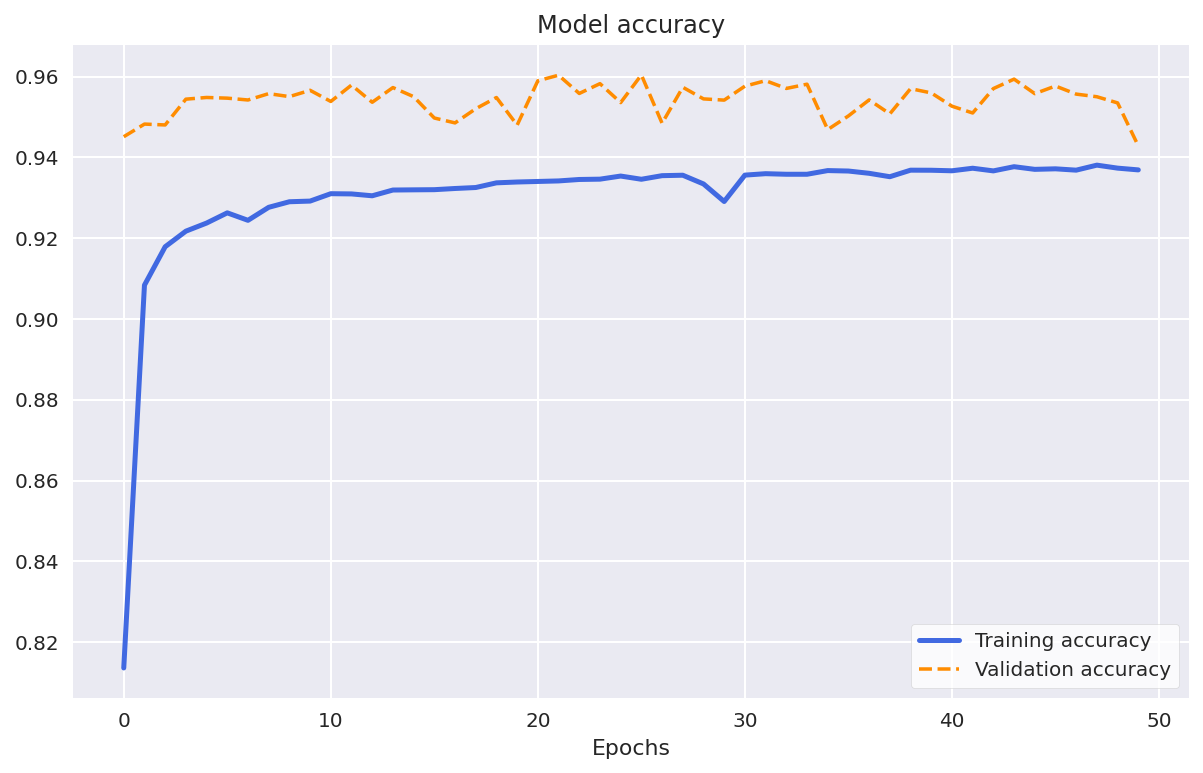

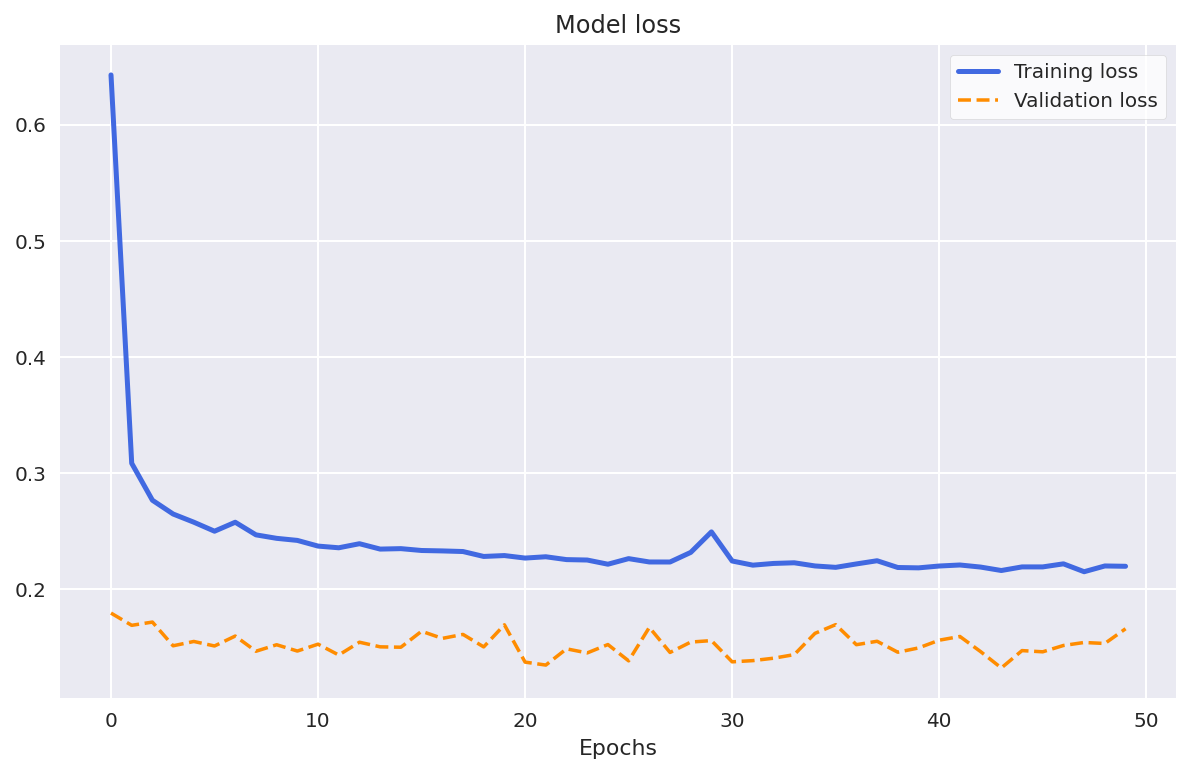

In [19]:
# Plot loss function
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model accuracy')
  plt.xlabel('Epochs')
  plt.plot(logs.history['accuracy'], c = 'royalblue', linewidth = 2.5, label = 'Training accuracy')
  plt.plot(logs.history['val_accuracy'], c = 'darkorange', linestyle = '--', label = 'Validation accuracy')
  plt.legend(frameon = True, facecolor = 'white')
plt.show()

plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model loss')
  plt.xlabel('Epochs')
  plt.plot(logs.history['loss'], c = 'royalblue', linewidth = 2.5, label = 'Training loss')
  plt.plot(logs.history['val_loss'], c = 'darkorange', linestyle = '--', label = 'Validation loss')
  plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [20]:
# Evaluate model
print(f'Model loss: {model.evaluate(X_test, y_test)[0]:.4f}, Model accuracy: {model.evaluate(X_test, y_test)[1]:.4f}')

2766/2766 [==============================] - 14s 5ms/step - loss: 0.1661 - accuracy: 0.9428
Model loss: 0.1661, Model accuracy: 0.9428


In [21]:
# Save model
model.save('ocr.model')

INFO:tensorflow:Assets written to: ocr.model/assets


In [22]:
# Prediction
label_names = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pred = model.predict(X_test).argmax(axis = 1) #Array of prediction results

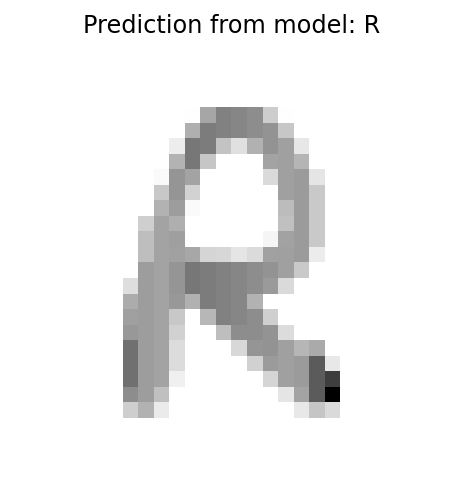

In [24]:
# Random test model
for i in np.random.choice(X_test.shape[0], 1):
  prediction = label_names[pred[i]]
  plt.imshow(X_test[i].reshape(28, 28), cmap = plt.cm.binary)
  plt.title(f'Prediction from model: {prediction}')
  plt.axis('off')
  plt.show()

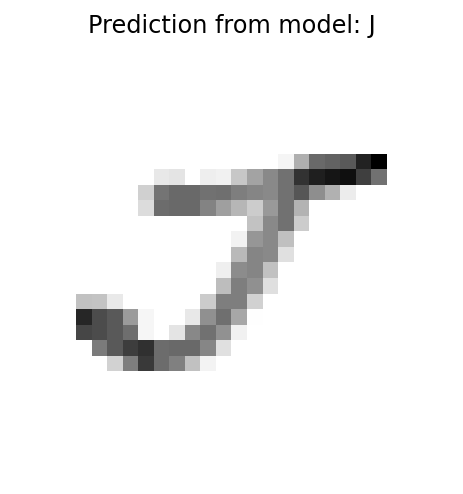

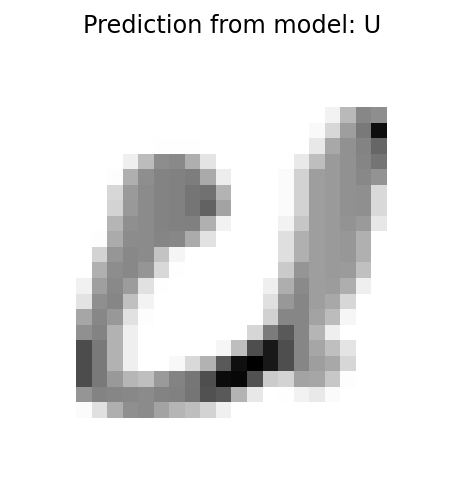

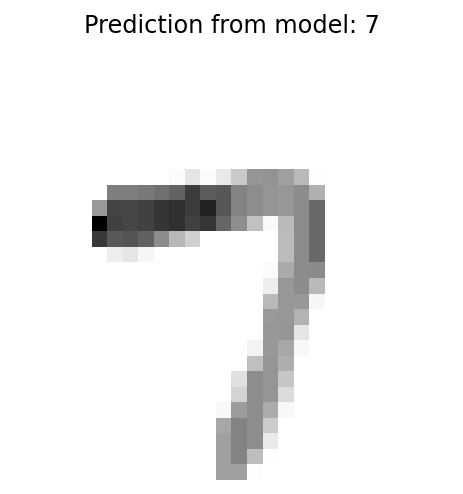

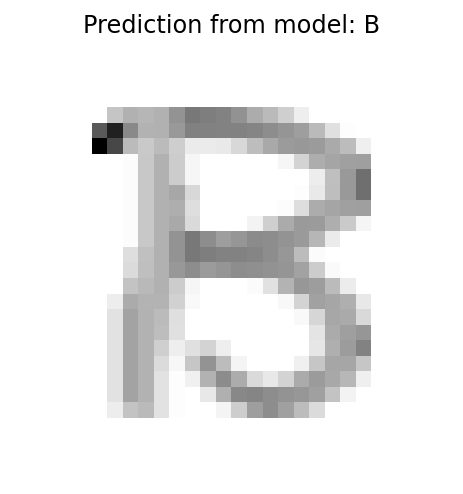

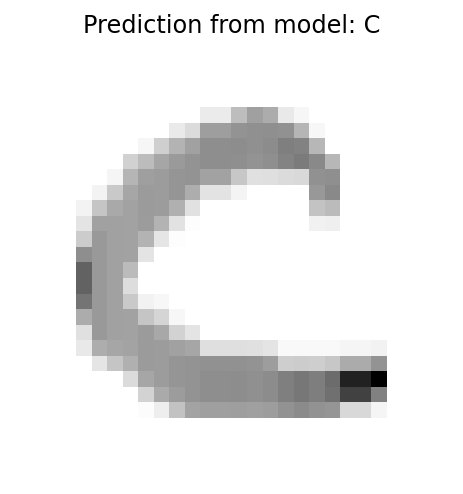

In [25]:
# Random test model
for i in range(45, 50):
  prediction = label_names[pred[i]]
  plt.imshow(X_test[i].reshape(28, 28), cmap = plt.cm.binary)
  plt.title(f'Prediction from model: {prediction}')
  plt.axis('off')
  plt.show()